#뉴스기사 요약해보기

##Step 1. 데이터 수집하기
##Step 2. 데이터 전처리하기 (추상적 요약)
 1) 실습 전처리
 2) 필요하다고 생각하는 전처리
 단, 불용어 제거시 상대적으로 짧은 요약 데이터에 대해서 불용어 제거할 것인지 고민할 것
##Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
 1) 시퀀스2시퀀스보다 어텐션 메커니즘이 좀 더 나은 성능 보임
 어텐션 메커니즘 설계해 볼 것
##Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
 1) 원래의 요약문(헤드라인열) 과 학습을 통해 얻은 추상적 요약의 결과를 비교할 것
##Step 5. Summa을 이용해서 추출적 요약해보기
 1) 추상적 요약은 추출적 요약과 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 난도가 높음
   반대로 말하면 추출적 요약은 추상적 요약에 비해 난도가 낮고 기존 문장에서 문장을 꺼내오기 때문에 잘못된 요약이 나올 가능성이 낮음.
   summa 의 summarize 를 사용하여 추출적 요약해볼 것.

   



In [1]:
#NLTK Lib install
!pip install nltk

#BeautifulSoup lib install
!pip install beautifulsoup4

#불용어 사전 다운로드
import nltk
nltk.download('stopwords')

#데이터 전처리 위한 나머지 패키지 로드
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request


[nltk_data] Downloading package stopwords to /home/ssac9/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#데이터 다운로드


import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')


In [3]:
#data sample check

data=pd.read_csv(os.getenv('HOME')+"/news_summary_more.csv",encoding='iso-8859-1')

data.sample(10)

,headlines,text
27601,MU to allow students who missed test over rain...,Mumbai University has announced that students ...
63369,Indoor pollution killed 1.24L across India in ...,Indoor pollution led to over 1.24 lakh prematu...
62356,What are the biggest data leaks in the world?,The Panama Papers leak from last year is the w...
27766,"No cutting of trees in Delhi till July 19, ord...",The National Green Tribunal (NGT) has directed...
57812,1 in 7 traffic cops suffers from breathing pro...,At least one in every seven traffic policemen ...
38063,"Shirish Kunder tweets 'Delhi L-G not working',...",Taking a dig at Delhi Lieutenant Governor Anil...
92237,US scientists to protest Trump policies in Was...,US scientists will stage a 'March for Science'...
47345,Mayor sends legal notice to Delhi CM for defam...,North Delhi mayor and BJP leader Preety Agarwa...
39015,If female models earn more then so should male...,Rafael Nadal has said that if female supermode...
57721,UK must apologise for Jallianwala Bagh massacr...,"It is time for the ""British government to fina..."


In [4]:
#text = train data set
#headlines = test data set

data = data[['text','headlines']]

#check null sample
print('텍스트 중복 제외한 유일한 샘플 : ', data['text'].nunique())
print('헤드라인 중복 제외한 유일한 샘플 : ', data['headlines'].nunique())

텍스트 중복 제외한 유일한 샘플 :  98360
헤드라인 중복 제외한 유일한 샘플 :  98280


In [5]:
#del duplicated sample

data.drop_duplicates(subset=['text'],inplace = True)
print('the number of samples :',(len(data)))

print(data.isnull().sum())



the number of samples : 98360
text         0
headlines    0
dtype: int64


In [6]:
#text normalization

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                          "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                          "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                          "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                          "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                          "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                          "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                          "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                          "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                          "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                          "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                          "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                          "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                          "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                          "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                          "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                          "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                          "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                          "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                          "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                          "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                          "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                          "you're": "you are", "you've": "you have"}
print("정규화 사전의 수: ",len(contractions))


정규화 사전의 수:  120


In [7]:
#kill stopwords

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))


불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [8]:
#data preprocess

def preprocess_sentence(sentence, remove_stopwords=True):
   sentence = sentence.lower() # 텍스트 소문자화
   sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
   sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
   sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
   sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
   sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
   sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
   sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
  
   # kill stop words (Text)
   if remove_stopwords:
       tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
   # ??? 불용어 미제거 (Summary)
   else:
       tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
   return tokens


In [9]:
#preparing error

! pip install lxml


In [10]:
#checking before/after

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.


everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [11]:
#checking the result which I preprocessed

clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다.
for s in data['text']:
   clean_text.append(preprocess_sentence(s))   #전처리 후 출력
clean_text[:5]


['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [12]:
clean_headlines = []  #전체 Headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
for s in data['headlines']:
   clean_headlines.append(preprocess_sentence(s, False))
clean_headlines[:5]


['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [13]:
#rechecking the empty sample again

data['text'] = clean_text
data['headlines'] = clean_headlines # 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

data.isnull().sum()


text         0
headlines    0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


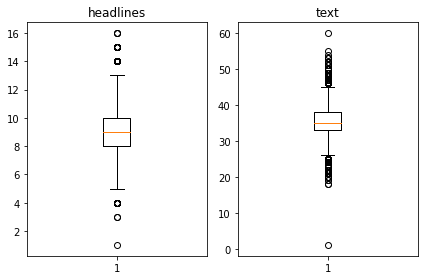

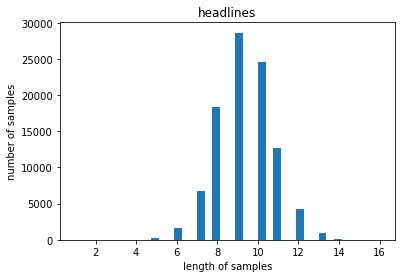

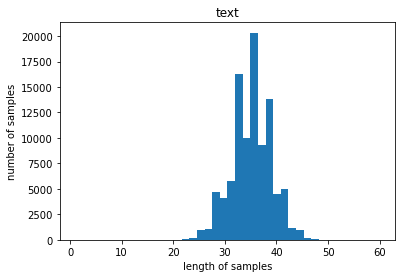

In [14]:
#set the maximum sample sentence

# 길이 분포 출력
import matplotlib.pyplot as plt
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
text_max_len = 50
headlines_max_len = 10


In [16]:
def below_threshold_len(max_len, nested_list):
 cnt = 0
 for s in nested_list:
   if(len(s.split()) <= max_len):
       cnt = cnt + 1
 print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


In [17]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])


전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [18]:
#add starting and ending token 
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()


,text,headlines,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,have known hirani for yrs what if metoo claims...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [19]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블


In [20]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)


[60253 69399 31570 ... 83636  7548 92278]


In [21]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]


In [22]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)


테스트 데이터의 수 : 19672


In [23]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))


훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [24]:
#tokenizer
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [26]:
#7번 미만 빈도수의 단어들은 제외하기
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
   total_freq = total_freq + value
   # 단어의 등장 빈도수가 threshold보다 작으면
   if(value < threshold):
       rare_cnt = rare_cnt + 1
       rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 69697
등장 빈도가 6번 이하인 희귀 단어의 수: 47557
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22140
단어 집합에서 희귀 단어의 비율: 68.23392685481441
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4991292005662915


In [27]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])


[[7, 1342, 175, 2349, 150, 14, 174, 1162, 19, 1615, 44, 90, 15, 3927, 68, 4411, 83, 1690, 1056, 74, 33, 1, 150, 14, 1869, 2318, 128, 6385, 660], [2414, 4215, 75, 154, 109, 372, 570, 466, 172, 487, 1040, 17, 147, 466, 806, 7367, 147, 92, 942, 35, 290, 158, 3086, 187, 796, 5101, 149, 187, 92, 2244, 884], [523, 135, 4120, 6991, 23, 4062, 1045, 5, 5489, 1100, 656, 4801, 205, 6812, 146, 620, 5998, 6813, 5489, 7264, 3351, 1684, 1045, 4801, 205, 6812, 1041, 656, 2311, 5824, 881, 4216, 3611]]


In [29]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)


In [30]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합​
# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
   total_freq = total_freq + value

# 단어의 등장 빈도수가 threshold보다 작으면
   if(value < threshold):
       rare_cnt = rare_cnt + 1
       rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 30061
등장 빈도가 5번 이하인 희귀 단어의 수: 19648
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10413
단어 집합에서 희귀 단어의 비율: 65.3604337846379
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.645632463770977


In [31]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)
#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])


input
input  [[1, 9494, 2001, 76, 551, 51, 7, 803, 52], [1, 541, 195, 1561, 2578, 707, 9495, 5, 88, 392, 1084], [1, 109, 4266, 2799, 1443, 1522, 546, 2693], [1, 4999, 362, 1165, 15, 8210, 3184, 36], [1, 159, 457, 9, 3, 1649, 7261, 54, 17, 370]]
target
decoder  [[9494, 2001, 76, 551, 51, 7, 803, 52, 2], [541, 195, 1561, 2578, 707, 9495, 5, 88, 392, 1084, 2], [109, 4266, 2799, 1443, 1522, 546, 2693, 2], [4999, 362, 1165, 15, 8210, 3184, 36, 2], [159, 457, 9, 3, 1649, 7261, 54, 17, 370, 2]]


In [32]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


/home/ssac9/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [33]:
#패딩 padding
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')


In [34]:
#designing the model

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256
# 인코더
encoder_inputs = Input(shape=(text_max_len,))
# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [35]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))
# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])


In [36]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

In [37]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [38]:
#어텐션 메커니즘

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer


In [39]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [40]:
#training the model

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
         validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
         batch_size = 256, callbacks=[es], epochs = 50)


Epoch 1/50
308/308 [==============================] - 131s 426ms/step - loss: 6.3469 - val_loss: 5.9294
Epoch 2/50
308/308 [==============================] - 130s 423ms/step - loss: 5.7548 - val_loss: 5.4854
Epoch 3/50
308/308 [==============================] - 130s 421ms/step - loss: 5.3509 - val_loss: 5.1939
Epoch 4/50
308/308 [==============================] - 130s 421ms/step - loss: 5.0461 - val_loss: 4.9486
Epoch 5/50
308/308 [==============================] - 129s 420ms/step - loss: 4.8019 - val_loss: 4.7713
Epoch 6/50
308/308 [==============================] - 130s 421ms/step - loss: 4.6060 - val_loss: 4.6507
Epoch 7/50
308/308 [==============================] - 130s 421ms/step - loss: 4.4387 - val_loss: 4.5399
Epoch 8/50
308/308 [==============================] - 130s 421ms/step - loss: 4.2905 - val_loss: 4.4491
Epoch 9/50
308/308 [==============================] - 128s 417ms/step - loss: 4.1650 - val_loss: 4.3798
Epoch 10/50
308/308 [==============================] - 129s 418m

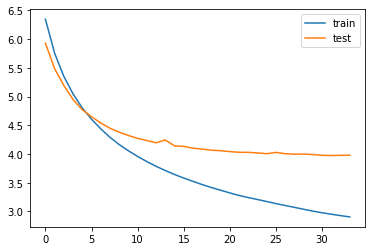

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [42]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


In [43]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
   [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
   [decoder_outputs2] + [state_h2, state_c2])

In [45]:
def decode_sequence(input_seq):
   # 입력으로부터 인코더의 상태를 얻음
   e_out, e_h, e_c = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 토큰 생성
   target_seq = np.zeros((1,1))
   target_seq[0, 0] = tar_word_to_index['sostoken']

   stop_condition = False
   decoded_sentence = ''
   while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

       output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
       sampled_token_index = np.argmax(output_tokens[0, -1, :])
       sampled_token = tar_index_to_word[sampled_token_index]

       if(sampled_token!='eostoken'):
           decoded_sentence += ' '+sampled_token

       #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
       if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
           stop_condition = True

       # 길이가 1인 타겟 시퀀스를 업데이트
       target_seq = np.zeros((1,1))
       target_seq[0, 0] = sampled_token_index

       # 상태를 업데이트 합니다.
       e_h, e_c = h, c

   return decoded_sentence


In [46]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
   temp=''
   for i in input_seq:
       if(i!=0):
           temp = temp + src_index_to_word[i]+' '
   return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
   temp=''
   for i in input_seq:
       if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
           temp = temp + tar_index_to_word[i] + ' '
   return temp


In [47]:
for i in range(50, 100):
   print("원문 :", seq2text(encoder_input_test[i]))
   print("실제 요약 :", seq2summary(decoder_input_test[i]))
   print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
   print("\n")

  

원문 : minor fire broke tesla car production factory california thursday evening ceo elon musk present site said caught fire musk thanked local fire department quick response containing fire injuries damage reported 
실제 요약 : fire breaks out at musk tesla factory in california 
예측 요약 :  tesla car catches fire while driving in us


원문 : mercedes british formula one driver lewis hamilton japanese grand prix sunday extend lead top drivers championship points red max daniel finished second third positions hamilton course win fourth championship four remaining season 
실제 요약 : hamilton wins japanese gp to extend ship lead to points 
예측 요약 :  driver wins race at grand prix


원문 : indian rupee thursday breached mark first time us dollar continuing losing streak foreign currency seventh consecutive session rupee nearly year date basis making worst performing currency asia rupee wednesday closed record low 
실제 요약 : rupee breaches mark against us dollar to hit new low 
예측 요약 :  rupee closes at fresh

예측 요약 :  trump afghan chief action is safe afghan prez trump


원문 : congress president rahul gandhi wednesday said whenever comes across bjp mps take steps back thinking hug fight someone mind hate choice gandhi said take pm bjp need hate added 
실제 요약 : mps take steps back thinking will hug them rahul gandhi 
예측 요약 :  bjp trying to learn about rahul gandhi


원문 : zomato user angry delay food delivery shared chat zomato customer support read every relationship ups say words sorry know words enough chat read customer shared chat online said went emotional 
실제 요약 : every relationship has its ups and zomato to angry customer 
예측 요약 :  zomato zomato user zomato zomato zomato zomato


원문 : cricketer robin ongoing australia india series clarified giving go instead playing ranji trophy recovering surgery continue play till enjoy anymore cannot physically tweeted year old last represented india july 
실제 요약 : doing commentary as am not fit on not playing ranji 
예측 요약 :  australian team cannot ke

예측 요약 :  karnataka congress mla dies after floor test




#추출적 요약 해보기


In [48]:
!pip install summa

In [49]:
import requests
from summa.summarizer import summarize


In [53]:
text = requests.get("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv").text

print(text[:1500])

headlines,text
upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."
Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."
New Zealand end Rohit Sharma-led India's 12-match winning streak,"New Zealand defeated India by 8 wickets in the fourth ODI at Ham

In [ ]:
print('headlines:')
print(summarize(text, ratio=0.005))

headlines:
